In [1]:
%load_ext autoreload
%autoreload 2

# Standard imports
import itertools
from pathlib import Path
import sys

# Library imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
import xarray as xr

# Util imports
sys.path.append("../../")

# Inverse distance weighting

In [2]:
CITY_NAME = "MetroManila"
STATION_NAMES = ["NAIA", "Port Area", "Science Garden"]
YEARS = [2007, 2008, 2009, 2016, 2017, 2018]
VARS = ["tmin", "tmax", "precip"]

FILL_NA = np.nan

RAW_PATH = Path("../../data/01-raw")
PROCESSED_PATH = Path("../../data/02-processed")
CORRECTED_PATH = PROCESSED_PATH / "bias-correction-radial-optimized"
CORRECTED_PATH.mkdir(parents=True, exist_ok=True)
CORRECTED_IMAGES_PATH = CORRECTED_PATH / "images"
CORRECTED_IMAGES_PATH.mkdir(parents=True, exist_ok=True)

DOMAINS_GEOJSON = RAW_PATH / "domains/downscaling_domains_fixed.geojson"
STATION_LOCATION_CSV = RAW_PATH / "station_data/PAGASA_station_locations.csv"
STATION_DATA_CSV = PROCESSED_PATH / "station_data/station_data.csv"

STATION_NC = CORRECTED_PATH / f"station_{CITY_NAME.lower()}.nc"
GRIDDED_NC = (
    PROCESSED_PATH
    / f"input/chirts_chirps_regridded_interpolated_{CITY_NAME.lower()}.nc"
)
GRIDDED_SUBSET_NC = CORRECTED_PATH / f"gridded_{CITY_NAME.lower()}.nc"

CORRECTED_NC = CORRECTED_PATH / f"corrected_gridded_{CITY_NAME.lower()}.nc"

In [3]:
station_locations_df = pd.read_csv(STATION_LOCATION_CSV)
station_locations_df.head()
station_lats = station_locations_df.loc[
    station_locations_df["station_name"].isin(STATION_NAMES), "lat"
].reset_index(drop=True)
station_lons = station_locations_df.loc[
    station_locations_df["station_name"].isin(STATION_NAMES), "lon"
].reset_index(drop=True)
station_lat = station_lats.item() if len(station_lats) == 1 else station_lats.mean()
station_lon = station_lons.item() if len(station_lons) == 1 else station_lons.mean()

In [4]:
stations_df = pd.read_csv(STATION_DATA_CSV)
station_df = (
    stations_df[stations_df["station"].isin(STATION_NAMES)]
    .drop_duplicates()
    .replace(-999, FILL_NA)
    .rename(columns={"rainfall": "precip"})
    .groupby(["station", "date"])
    .mean()
    .sort_values("date")
    .reset_index()
)
station_df["date"] = pd.DatetimeIndex(station_df["date"])
station_df.head()

,station,date,precip,tmax,tmin,tmean,rh,wind_speed,wind_direction
0,NAIA,2007-01-01,0.0,31.4,25.3,28.4,72.0,2.0,90.0
1,Port Area,2007-01-01,0.0,32.5,25.0,28.8,67.0,2.0,90.0
2,Science Garden,2007-01-01,0.4,30.9,23.3,27.1,78.0,1.0,360.0
3,NAIA,2007-01-02,NaN,31.1,25.1,28.1,78.0,2.0,120.0
4,Port Area,2007-01-02,0.0,31.0,26.0,28.5,77.0,2.0,40.0


In [8]:
# mask out dubious data
exclude_data = (station_df["date"]<'2010-01-01')&(station_df["station"]=='NAIA')
station_df.loc[exclude_data, 'precip'] = np.nan

In [15]:
gridded_all_time_ds = xr.open_dataset(GRIDDED_NC, engine="scipy").sel(band=1)
gridded_ds = gridded_all_time_ds.isel(time=gridded_all_time_ds.time.dt.year.isin(YEARS))

In [16]:
gridded_ds

<xarray.Dataset>
Dimensions:      (time: 2192, lat: 30, lon: 20)
Coordinates:
  * time         (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2018-12-31
  * lat          (lat) float64 14.27 14.29 14.31 14.33 ... 14.81 14.83 14.85
  * lon          (lon) float64 120.8 120.9 120.9 120.9 ... 121.2 121.2 121.2
    band         int32 1
    spatial_ref  int32 ...
Data variables:
    tmin         (time, lat, lon) float32 ...
    tmax         (time, lat, lon) float32 ...
    precip       (time, lat, lon) float32 ...
Attributes: (12/16)
    Conventions:    CF-1.6
    title:          dataVersion 1.0
    history:        created by Climate Hazards Center
    version:        Version 1.0
    date_created:   2023-05-15
    creator_name:   Pete Peterson
    ...             ...
    website:        https://chc.ucsb.edu/data/chirtsmonthly    https://chc.uc...
    comments:       
    reference-1:    Funk, C. et al. A high-resolution 1983–2016 Tmax climate ...
    reference-2:    Verdin, A. et al. Development and validation of the CHIRT...
    reference-3:    Tuholske, C., Caylor, K., Funk, C., Verdin, A., Sweeney, ...
    regrid_method:  bilinear

## IDW with Scikit-Learn

In [10]:
gridded_lats = gridded_ds["lat"].to_numpy()
gridded_lons = gridded_ds["lon"].to_numpy()
gridded_df = pd.DataFrame(
    list(itertools.product(gridded_lats, gridded_lons)), columns=["lat", "lon"]
)

time_df = pd.DatetimeIndex(gridded_ds["time"].values)

nlat = len(gridded_lats)
nlon = len(gridded_lons)
ntime = len(time_df)

In [11]:
# X_df = pd.DataFrame(dict(lat=station_lats,lon=station_lons))
# y_df = pd.DataFrame(dict(precip=[0.0,0.3,np.nan])) #station_df.loc[station_df["date"] == time_df[k],var].reset_index(drop=True)

In [12]:
interpolated_ds = gridded_ds[VARS].copy()
for var in VARS:
    print(f"Now doing {var}")

    interpolated_arr = np.zeros((ntime, nlat * nlon))

    for k in range(ntime):
        X_df = pd.DataFrame(dict(lat=station_lats, lon=station_lons))
        y_df = station_df.loc[station_df["date"] == time_df[k], var].reset_index(
            drop=True
        )
        len_not_na = y_df.notna().sum()

        if len_not_na > 0:
            model = KNeighborsRegressor(
                algorithm="kd_tree", n_neighbors=len_not_na, weights="distance"
            )

            model.fit(
                X=X_df[y_df.notna()],
                y=y_df[y_df.notna()],
            )
            interpolated_arr[k] = model.predict(gridded_df)

    interpolated_da = gridded_ds[var].copy()
    interpolated_da.values = interpolated_arr.reshape((ntime, nlat, nlon))
    interpolated_ds[var] = interpolated_da.where(gridded_ds[var].isel(time=0).notnull())
interpolated_ds

Now doing tmin
Now doing tmax
Now doing precip


<xarray.Dataset>
Dimensions:      (time: 2192, lat: 30, lon: 20)
Coordinates:
  * time         (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2018-12-31
  * lat          (lat) float64 14.27 14.29 14.31 14.33 ... 14.81 14.83 14.85
  * lon          (lon) float64 120.8 120.9 120.9 120.9 ... 121.2 121.2 121.2
    band         int32 1
    spatial_ref  int32 ...
Data variables:
    tmin         (time, lat, lon) float64 24.67 24.67 24.68 ... nan nan nan
    tmax         (time, lat, lon) float64 31.63 31.63 31.63 ... nan nan nan
    precip       (time, lat, lon) float64 0.178 0.1782 0.1785 ... nan nan nan
Attributes: (12/16)
    Conventions:    CF-1.6
    title:          dataVersion 1.0
    history:        created by Climate Hazards Center
    version:        Version 1.0
    date_created:   2023-05-15
    creator_name:   Pete Peterson
    ...             ...
    website:        https://chc.ucsb.edu/data/chirtsmonthly    https://chc.uc...
    comments:       
    reference-1:    Funk, C. et al. A high-resolution 1983–2016 Tmax climate ...
    reference-2:    Verdin, A. et al. Development and validation of the CHIRT...
    reference-3:    Tuholske, C., Caylor, K., Funk, C., Verdin, A., Sweeney, ...
    regrid_method:  bilinear

In [13]:
# Run if you want to save only the interpolated varsion
#interpolated_ds.to_netcdf(CORRECTED_NC, engine="scipy")

In [80]:
# Preserve spatial variation of gridded data using weighted averaging
# Assume 60% for gridded, 40% for station
weighted_avg_ds = interpolated_ds.copy()
for VAR in VARS:
    weighted_avg_ds[VAR] = (0.6*interpolated_ds[VAR]+0.4*gridded_ds[VAR]) 

In [86]:
weighted_avg_ds

<xarray.Dataset>
Dimensions:      (time: 2192, lat: 30, lon: 20)
Coordinates:
  * time         (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2018-12-31
  * lat          (lat) float64 14.27 14.29 14.31 14.33 ... 14.81 14.83 14.85
  * lon          (lon) float64 120.8 120.9 120.9 120.9 ... 121.2 121.2 121.2
    band         int32 1
    spatial_ref  int32 ...
Data variables:
    tmin         (time, lat, lon) float64 25.42 25.34 25.25 ... nan nan nan
    tmax         (time, lat, lon) float64 31.19 31.14 31.08 ... nan nan nan
    precip       (time, lat, lon) float64 0.1068 0.1069 0.1071 ... nan nan nan
Attributes: (12/16)
    Conventions:    CF-1.6
    title:          dataVersion 1.0
    history:        created by Climate Hazards Center
    version:        Version 1.0
    date_created:   2023-05-15
    creator_name:   Pete Peterson
    ...             ...
    website:        https://chc.ucsb.edu/data/chirtsmonthly    https://chc.uc...
    comments:       
    reference-1:    Funk, C. et al. A high-resolution 1983–2016 Tmax climate ...
    reference-2:    Verdin, A. et al. Development and validation of the CHIRT...
    reference-3:    Tuholske, C., Caylor, K., Funk, C., Verdin, A., Sweeney, ...
    regrid_method:  bilinear

In [87]:
weighted_avg_ds.to_netcdf(CORRECTED_NC, engine="scipy")

### Plot samples

In [88]:
t_idx=182
var='precip'

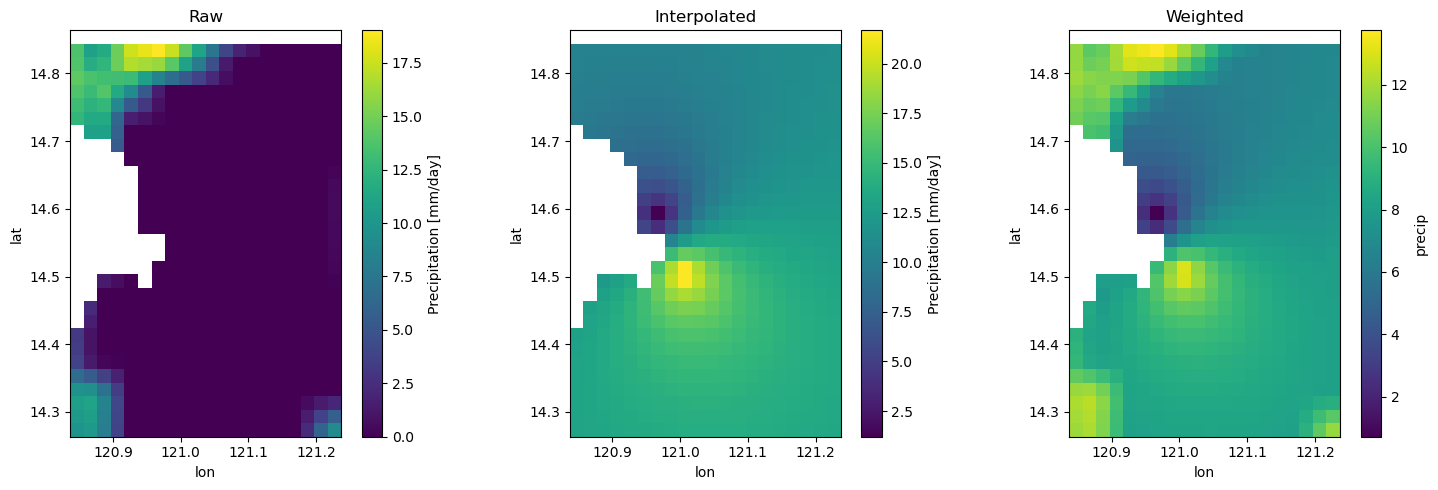

In [89]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
titles = ['Raw','Interpolated','Weighted']
for i,ds in enumerate([gridded_ds,interpolated_ds, weighted_avg_ds]):
    ds[var][t_idx].plot(ax=axs[i])
    axs[i].set_aspect(1)
    axs[i].set_title(titles[i])
fig.tight_layout()